# KNN Regression of Redshifts

In [2]:
from astroclip.utils import load_config, format_axes
from astroclip.training_utils import create_dataloaders, get_cross_modal_transforms
import matplotlib.pyplot as plt

import torch
import numpy as np
import os
from tqdm import tqdm

/Users/adnansiddiquei/miniconda3/envs/astroclip_env/lib/python3.12/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adnansiddiquei/miniconda3/envs/astroclip_env/lib/python3.12/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adnansiddiquei/miniconda3/envs/astroclip_env/lib/python3.12/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/Use

## Load the data, and generated embeddings

In [117]:
config, hparams = load_config('local', 'generate_embeddings')

cache_dir = config['cache_dir']
output_dir = config['output_dir']

batch_size = hparams['batch_size']
num_workers = config['astroclip']['num_workers']

dataset, train_loader, val_loader = create_dataloaders(cache_dir, batch_size, num_workers, val_drop_last=False)

redshifts = torch.load(f'{cache_dir}/redshifts.pt').numpy()
valid_indices = torch.load(f'{cache_dir}/valid_indices.pt').numpy()
spectrum_embeddings = torch.load(f'{cache_dir}/spectrum_embeddings.pt').numpy()
image_embeddings = torch.load(f'{cache_dir}/image_embeddings.pt').numpy()

print(spectrum_embeddings.shape, image_embeddings.shape, redshifts.shape, valid_indices.shape)
print(f'{redshifts.shape[0] - valid_indices.shape[0]} items were dropped during training with the cross_modal_transforms.'
      f'These will be factored out when doing any analysis.')

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

In [118]:
print(spectrum_embeddings.shape, image_embeddings.shape, redshifts.shape, valid_indices.shape)

(39599, 128) (39599, 128) (39599,) (39219,)


In [119]:
39599 - 39219

380

In [96]:
valid_indices = torch.load(f'{cache_dir}/valid_indices.pt').numpy()

In [102]:
spectrum_embeddings2

array([[-0.03726815,  0.0234044 ,  0.029487  , ...,  0.14928032,
         0.09428269,  0.03759045],
       [-0.01613518, -0.20619296, -0.01713521, ...,  0.11360248,
         0.05078218, -0.2544794 ],
       [ 0.04819671, -0.02170525,  0.02232363, ...,  0.07332995,
        -0.04107346, -0.07451925],
       ...,
       [ 0.06976679,  0.00205801, -0.10279869, ...,  0.02336329,
         0.09435941, -0.09762804],
       [-0.07154534,  0.02489059, -0.12121733, ..., -0.03185954,
         0.12917267, -0.10696043],
       [-0.08749762, -0.12420253,  0.13282719, ..., -0.07705134,
         0.18724994,  0.00254323]], dtype=float32)

In [101]:
spectrum_embeddings

array([[-0.03727316,  0.0234092 ,  0.02952003, ...,  0.14929047,
         0.09415256,  0.03764625],
       [-0.01612725, -0.2062652 , -0.01709622, ...,  0.11357857,
         0.05066378, -0.2544301 ],
       [ 0.04813306, -0.02166503,  0.02242345, ...,  0.07334661,
        -0.04111074, -0.07452267],
       ...,
       [ 0.00120935,  0.04481279,  0.02301659, ..., -0.03478185,
         0.1064245 , -0.05674319],
       [-0.05479719, -0.03442834, -0.01574927, ..., -0.14715858,
         0.10545981,  0.00145977],
       [-0.01754819, -0.13432595, -0.03436079, ..., -0.06166181,
         0.11034586, -0.06707457]], dtype=float32)

## Define some utility functions

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score

def predict_redshifts(source_embedding, target_embedding, redshifts, n_neighbours=16):
    """
    Predict redshift for the embeddings given in source_embeddings, using their closest neighbours in
    target_embeddings.
    """
    assert (
        source_embedding.shape[0] == target_embedding.shape[0]
    ), 'Embeddings must have the same dimension'
    assert (
        source_embedding.shape[1] == target_embedding.shape[1]
    ), 'Embeddings must have the same dimension'
    
    num_embeddings = source_embedding.shape[0]
    actual_redshifts = redshifts[0 : target_embedding.shape[0]]

    neighbours = NearestNeighbors(n_neighbors=n_neighbours, algorithm='auto').fit(
        target_embedding
    )
    
    distances, indices = neighbours.kneighbors(source_embedding)
    predicted_redshifts = np.array(
        [actual_redshifts[indices[i]].mean() for i in range(num_embeddings)]
    )
    
    return actual_redshifts, predicted_redshifts

def plot_r2_score(ax, redshifts, predicted_redshifts, title):
    r2 = r2_score(redshifts, predicted_redshifts)
    
    ax.scatter(redshifts, predicted_redshifts, s=1)
    ax.set_xlim(-0.05, 0.85)
    ax.set_ylim(-0.05, 0.85)
    ax.plot(np.linspace(0, 0.8, 100), np.linspace(0, 0.8, 100), color='orange', linestyle='--')
    
    ax.set_xlabel('True redshift')
    ax.set_ylabel('Predicted redshift')
    ax.text(0.05, 0.7, rf'$R^2$ score = {r2:.2f}', fontsize=12)
    ax.set_title(title, fontsize=10)

## Predict the redshifts

In [47]:
actual_redshifts, ss_predicted_redshifts = predict_redshifts(
    spectrum_embeddings, spectrum_embeddings, val_redshifts
)

# actual_redshifts, ii_predicted_redshifts = predict_redshifts(image_embeddings, image_embeddings, redshifts)
# actual_redshifts, si_predicted_redshifts = predict_redshifts(spectrum_embeddings, image_embeddings, redshifts)
# actual_redshifts, is_predicted_redshifts = predict_redshifts(image_embeddings, spectrum_embeddings, redshifts)

## Make the plots

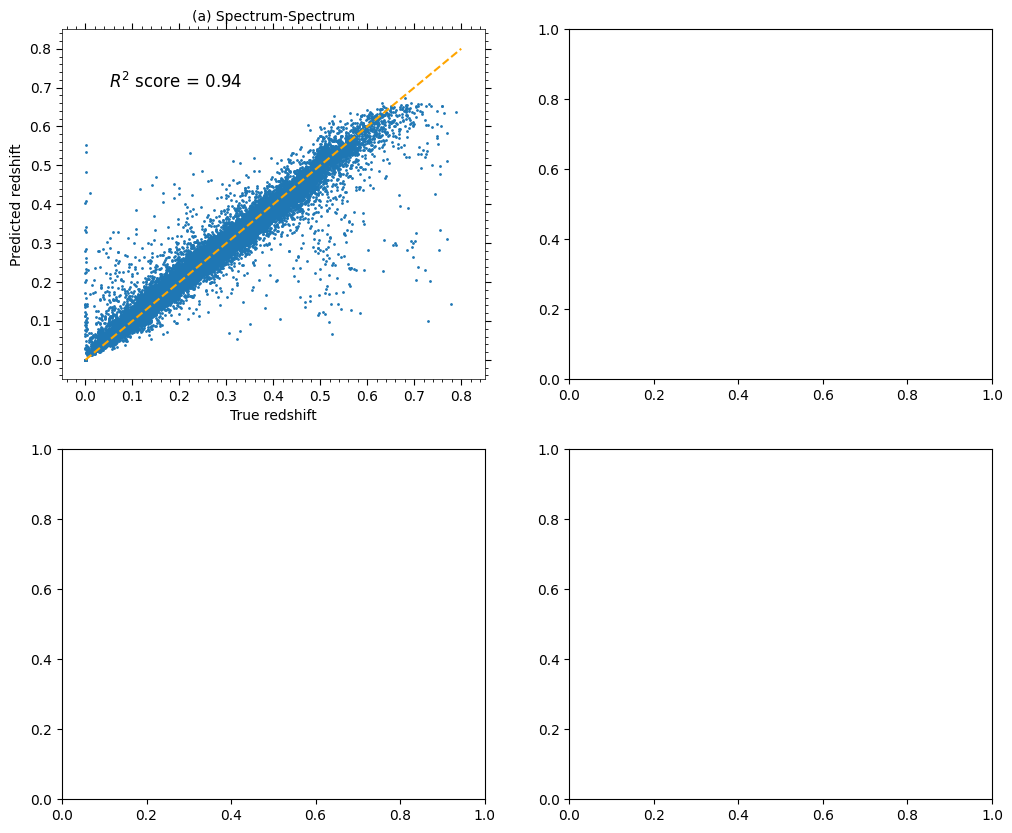

In [48]:
fig, ax = plt.subplots(figsize=(12, 10), nrows=2, ncols=2)
plot_r2_score(ax[0, 0], actual_redshifts, ss_predicted_redshifts, title='(a) Spectrum-Spectrum')
# plot_r2_score(ax[0, 1], actual_redshifts, ii_predicted_redshifts, title='(b) Image-Image')
# plot_r2_score(ax[1, 0], actual_redshifts, si_predicted_redshifts, title='(c) Spectrum-Image')
# plot_r2_score(ax[1, 1], actual_redshifts, is_predicted_redshifts, title='(d) Image-Spectrum')

format_axes(ax[0, 0])
# format_axes(ax[0, 1])
# format_axes(ax[1, 0])
# format_axes(ax[1, 1])

# plt.show()
# plt.savefig('../out/redshift_knn_regression.png', bbox_inches='tight')